## Section 1. Libraries

In [1]:
import numpy
import matplotlib.pyplot
import sys
import os
import torch
import yaml
import pandas
import torch
import tensorflow

sys.path.append(os.path.join(sys.path[0], '../'))

from src.utils.load_data import load_data
from src.utils.utils_Alibi_proto import search_counterfactuals_Alibi_Proto
from src.utils.metrics_functions import compute_metrics
from src.cost_policy.cost_policy_for_datasets import funcion_costes_numpy
from src.benchmarks.Basic_MLP import Basic_MLP

tensorflow.get_logger().setLevel(40) # suppress deprecation messages
tensorflow.compat.v1.disable_v2_behavior()

%load_ext autoreload
%autoreload 2

c:\Users\javim\miniconda3\envs\testing_ALIBI_bueno\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TypeError: issubclass() arg 1 must be a class

In [1]:
"""numpy==1.22.4#1.21.5#1.16.4
pandas==1.4.2#0.24.0
matplotlib==3.5.1#3.1.0
torch==1.13.0#1.1.0
tensorflow==2.12.0#2.10.0
alibi==0.9.2#0.8.0
transformers==4.29.2#4.23.1 ??
spacy==3.5.3#3.4.1 ??
keras-preprocessing==1.1.2
huggingface-hub==0.14.1#0.10.1
ipykernel==6.9.1#6.15.0
PyYAML==6.0
tqdm==4.64.0"""

'numpy==1.22.4#1.21.5#1.16.4\npandas==1.4.2#0.24.0\nmatplotlib==3.5.1#3.1.0\ntorch==1.13.0#1.1.0\ntensorflow==2.12.0#2.10.0\nalibi==0.9.2#0.8.0\ntransformers==4.29.2#4.23.1 ??\nspacy==3.5.3#3.4.1 ??\nkeras-preprocessing==1.1.2\nhuggingface-hub==0.14.1#0.10.1\nipykernel==6.9.1#6.15.0\nPyYAML==6.0\ntqdm==4.64.0'

In [2]:
"""!pip show tqdm"""

'!pip show tqdm'

## Section 2. Load params from yaml

In [2]:
name_method = 'Alibi_proto'

with open(f'../conf/{name_method}_method_params.yaml') as f:
    params = yaml.load(f, Loader=yaml.loader.SafeLoader)

########## Paths ##########
path_save_counterfactual = "../results/re-computing_counterfactual_explanations/"
path_precomputed_counterfactuals = "../results/pre-computed_counterfactual_explanations/"
path_pretrained_model = "../data/pretrained_clasification_models/"
path_data = "../data/datasets/"
###########################

## Compute the metrics and results table from pre-searched counterfactuals

If you want to compute the results of the RE-computed counterfactuals you must to change the variable 'use_precomputed_counterfactuals' from True to False.

***[WARNING]***: This just modify the path where to load the counterfactuals, but the folder "re-computed_counterfactual_explanations" is empty by default. To re-compute the experiments you must re-execute the desired experiments with the **Section 3** of this notebook.

Also if necesary, you can comment some names in the variables 'dataset_name_list' and 'model_name_list' in case you only want to compute the metrics for a specific combination of dataset and/or explanation method.

In [3]:
########### Modificable params ###########
dataset_name_list = [  # Comment any dataset to not compute the metrics of its counterfactuals.
                     'MKT',
                     'TCC',
                     'CCF',
                     'HMEQ',
                     'CS1',
                     'CS2',
                     ]
method_name_list = [  # Comment any method to not compute the metrics of its counterfactuals.
                    'Proposed',
                    'Alibi_proto',
                    'Alibi_cem',
                    'GRACE'
                    ]
use_precomputed_counterfactuals = True  # Change to False for compute metrics of RE-computed counterfactuals.
verbose = False
##########################################

if use_precomputed_counterfactuals:
    # To compute the resulting metrics of the PRE-computed counterfactuals
    load_experiments_path = path_precomputed_counterfactuals
else:
    # To compute the resulting metrics of the RE-computed counterfactuals
    load_experiments_path = path_save_counterfactual

final_results = compute_metrics(method_name_list=method_name_list,
                                dataset_name_list=dataset_name_list,
                                load_experiments_path=load_experiments_path,
                                verbose=verbose)

global_mean_distance = final_results['global_mean_distance']
global_succeed_ratio = final_results['global_succeed_ratio']
global_counter_savings = final_results['global_counter_savings']
global_results_dict = final_results['global_results_dict']

print("\n\n[Table Results]: Counter Savings")
display(pandas.DataFrame(global_counter_savings).transpose())

print("\n\n[Table Results]: Success Ratio")
display(pandas.DataFrame(global_succeed_ratio).transpose())

print("\n\n[Table Results]: Mean Distance")
display(pandas.DataFrame(global_mean_distance).transpose())



[Table Results]: Counter Savings


,MKT,TCC,CCF,HMEQ,CS1,CS2
Proposed,68.77,72.55,99.60,85.03,98.18,90.97
Alibi_proto,59.44,57.87,68.98,65.76,65.03,54.54
Alibi_cem,54.80,63.19,55.91,65.63,62.54,54.10
GRACE,53.53,57.48,65.02,64.14,67.79,53.36




[Table Results]: Success Ratio


,MKT,TCC,CCF,HMEQ,CS1,CS2
Proposed,82.73,100.00,99.19,99.63,92.63,81.36
Alibi_proto,96.28,100.00,100.00,95.15,95.39,100.00
Alibi_cem,80.93,100.00,34.15,80.22,87.01,100.00
GRACE,76.81,3.39,52.85,84.70,85.93,98.97




[Table Results]: Mean Distance


,MKT,TCC,CCF,HMEQ,CS1,CS2
Proposed,2.33,2.68,7.99,0.57,1.02,9.77
Alibi_proto,2.06,0.82,9.56,0.98,0.33,0.46
Alibi_cem,0.61,0.92,0.99,0.92,0.45,0.44
GRACE,1.24,0.30,3.78,3.15,28.76,0.46


## [Optional]  Section 3. Reproduce the counterfactual searching over all datasets

**[Warning]** This may take a high amount of time depending on the dataset. An aproximation of the duration of the search of each dataset is:
- HMEQ:
- TCC: 4 min
- MKT:
- CS1:
- CS2:

**[Important]** Due to the execution times, we carefully recoment to reproduce the experiments one by one. This can be perform just by only leave one dataset name uncommented in the 'list_datasets' variable in the next cell.



__________________________________________________
Searching Counterfactuals on MKT dataset

[Process] START data loading
[Data Info] Imbalance ratio (IR) = P0/P1 = N0/N1 || total: 6.9	 || tr: 6.9	 || ts: 6.9
[Data Info] mean(1/Qc = (c01 - c11)/(c10 - c00)) || total: 1.0305924488151709e+17	 || tr: 1.0283312911879746e+17	 || ts: 1.03737568325348e+17
[Data Info] shape: 32 dims for 37931 samples || Train/Test = 75/25 [%]
[Process] DONE data loading


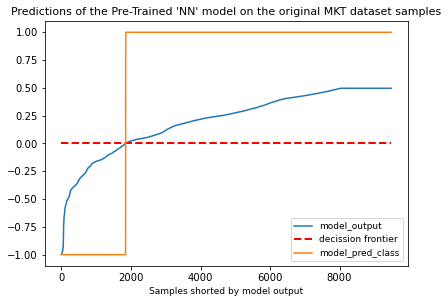


[Process] START counterfactual search


No encoder specified. Using k-d trees to represent class prototypes.
100%|██████████| 2/2 [00:04<00:00,  2.15s/it]

Not found counter: 0/2
Found counter:     2/2. From those 2 have a minimal distance


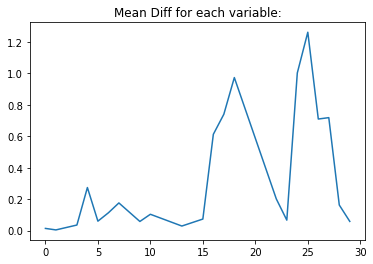

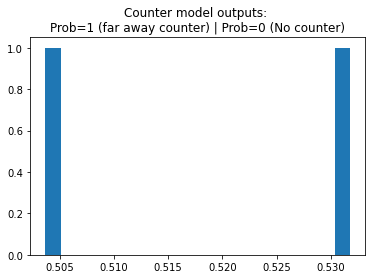

[Process] DONE counterfactual search
__________________________________________________


__________________________________________________
Searching Counterfactuals on TCC dataset

[Process] START data loading
[Data Info] Imbalance ratio (IR) = P0/P1 = N0/N1 || total: 2.8	 || tr: 2.8	 || ts: 2.8
[Data Info] mean(1/Qc = (c01 - c11)/(c10 - c00)) || total: 4.0	 || tr: 4.0	 || ts: 4.0
[Data Info] shape: 26 dims for 7043 samples || Train/Test = 75/25 [%]
[Process] DONE data loading


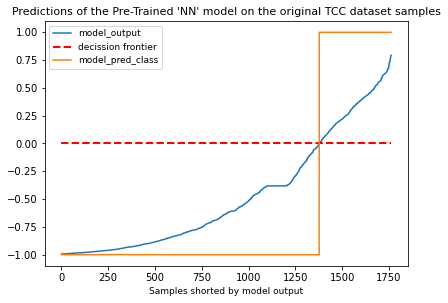


[Process] START counterfactual search


No encoder specified. Using k-d trees to represent class prototypes.
100%|██████████| 2/2 [00:55<00:00, 27.87s/it]

Not found counter: 0/2
Found counter:     2/2. From those 2 have a minimal distance


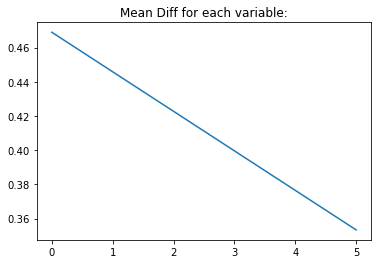

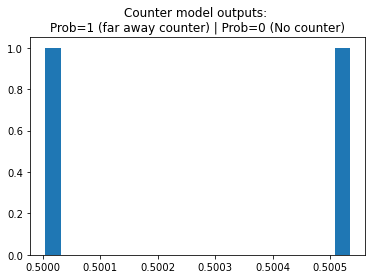

[Process] DONE counterfactual search
__________________________________________________


__________________________________________________
Searching Counterfactuals on CCF dataset

[Process] START data loading
[Data Info] Imbalance ratio (IR) = P0/P1 = N0/N1 || total: 57.8	 || tr: 57.8	 || ts: 57.8
[Data Info] mean(1/Qc = (c01 - c11)/(c10 - c00)) || total: 14.9	 || tr: 14.9	 || ts: 14.9
[Data Info] shape: 29 dims for 28922 samples || Train/Test = 75/25 [%]
[Process] DONE data loading


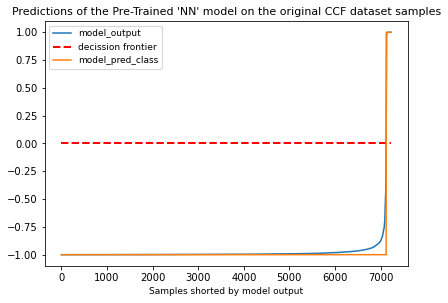

No encoder specified. Using k-d trees to represent class prototypes.



[Process] START counterfactual search


100%|██████████| 2/2 [00:56<00:00, 28.02s/it]

Not found counter: 0/2
Found counter:     2/2. From those 1 have a minimal distance


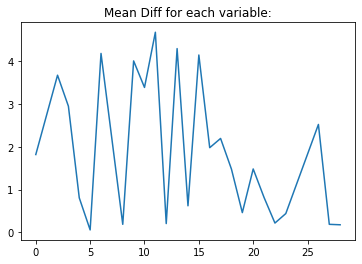

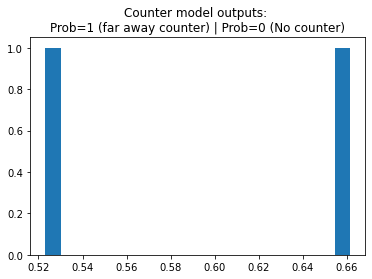

[Process] DONE counterfactual search
__________________________________________________


__________________________________________________
Searching Counterfactuals on HMEQ dataset

[Process] START data loading
[Data Info] Imbalance ratio (IR) = P0/P1 = N0/N1 || total: 4.0	 || tr: 4.0	 || ts: 4.0
[Data Info] mean(1/Qc = (c01 - c11)/(c10 - c00)) || total: 5.0	 || tr: 5.0	 || ts: 5.0
[Data Info] shape: 20 dims for 5960 samples || Train/Test = 75/25 [%]
[Process] DONE data loading


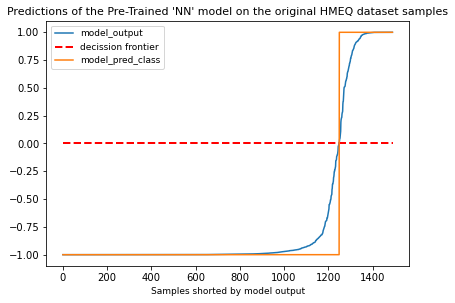

No encoder specified. Using k-d trees to represent class prototypes.



[Process] START counterfactual search


100%|██████████| 2/2 [00:12<00:00,  6.05s/it]

Not found counter: 0/2
Found counter:     2/2. From those 2 have a minimal distance


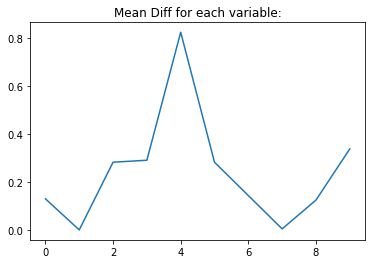

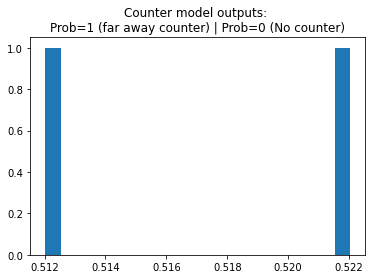

[Process] DONE counterfactual search
__________________________________________________


__________________________________________________
Searching Counterfactuals on CS1 dataset

[Process] START data loading
[Data Info] Imbalance ratio (IR) = P0/P1 = N0/N1 || total: 13.8	 || tr: 13.8	 || ts: 13.8
[Data Info] mean(1/Qc = (c01 - c11)/(c10 - c00)) || total: 13.8	 || tr: 13.8	 || ts: 13.8
[Data Info] shape: 10 dims for 112915 samples || Train/Test = 75/25 [%]
[Process] DONE data loading


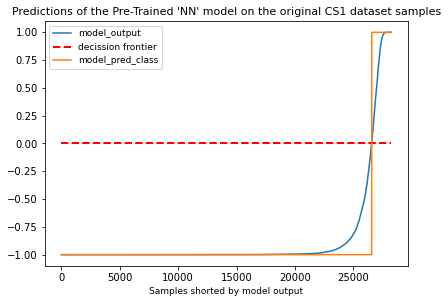

No encoder specified. Using k-d trees to represent class prototypes.



[Process] START counterfactual search


100%|██████████| 2/2 [00:04<00:00,  2.37s/it]

Not found counter: 0/2
Found counter:     2/2. From those 0 have a minimal distance


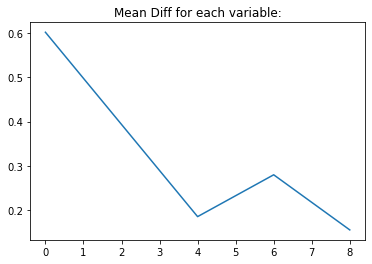

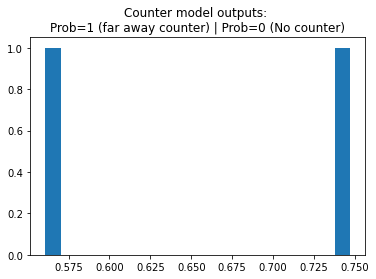

[Process] DONE counterfactual search
__________________________________________________


__________________________________________________
Searching Counterfactuals on CS2 dataset

[Process] START data loading
[Data Info] Imbalance ratio (IR) = P0/P1 = N0/N1 || total: 4.0	 || tr: 4.0	 || ts: 4.0
[Data Info] mean(1/Qc = (c01 - c11)/(c10 - c00)) || total: 6.37027030253223e+17	 || tr: 6.362073683868095e+17	 || ts: 6.394858474576271e+17
[Data Info] shape: 34 dims for 38938 samples || Train/Test = 75/25 [%]
[Process] DONE data loading


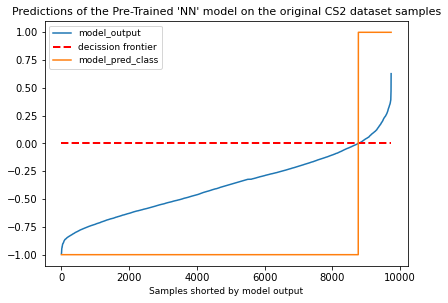

No encoder specified. Using k-d trees to represent class prototypes.



[Process] START counterfactual search


100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

Not found counter: 0/2
Found counter:     2/2. From those 2 have a minimal distance


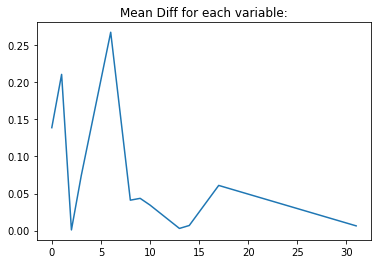

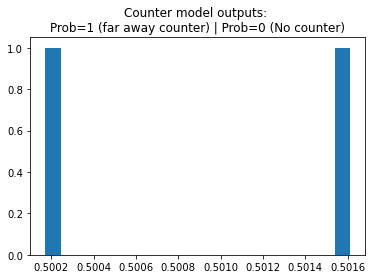

[Process] DONE counterfactual search
__________________________________________________


In [4]:
########### Modificable params ###########
dataset_name_list = [  # Comment any dataset to not compute the metrics of its counterfactuals.
                     'MKT',
                     'TCC',
                     'CCF',
                     'HMEQ',
                     'CS1',
                     'CS2',
                     ]
save_results = True
verbose = 1  # [0: no prints; 1: high level information; 2: full detail]. [Warning] there is a level 3, but it saturates the output console
             # so if necesary, just use it for a single sample on a single dataset.
figure = False  # [Warning]: This params displays a set of charts by each sample of each dataset.
#                 Just activate then executing with a small amount of samples on a single dataset.
plot_resume_of_dataset_outputs = True
small_test = True
##########################################

for name_dataset in dataset_name_list:

    print("\n")
    print("__________________________________________________")
    print(f"Searching Counterfactuals on {name_dataset} dataset")
    loaded_dataset = load_data(name_dataset=name_dataset,
                               path_data=path_data,
                               verbose=verbose)

    ############ Create explainable model ############
    # Load pretrained NN weights
    file_load_NN_weights = f"{name_dataset}_NN_weights.txt"
    direccion_resultado = path_pretrained_model + file_load_NN_weights
    weights_pretrained_model = torch.load(direccion_resultado)

    # Initializing the NN model with the pretrained NN params
    tensor_x_ts = loaded_dataset['tensor_x_ts']
    basic_MLP_model = None
    basic_MLP_model = Basic_MLP(name_dataset=name_dataset, 
                                pretrained_weights=weights_pretrained_model,
                                input_size=tensor_x_ts.shape[1],
                                hidden_size=params[name_dataset]['NN']
                                )
    ##################################################

    if plot_resume_of_dataset_outputs:
        prob_pred_orig_ts = basic_MLP_model.forward(tensor_x_ts).detach().numpy().flatten()
        y_pred_orig_ts = basic_MLP_model.predict_class(x_input=tensor_x_ts).astype(int)

        index_sort = prob_pred_orig_ts.argsort()
        x_max = y_pred_orig_ts.sum()
        matplotlib.pyplot.figure(figsize=(6.5, 4.5))
        matplotlib.pyplot.plot(prob_pred_orig_ts[index_sort], label='model_output')
        matplotlib.pyplot.hlines(y=0.0, xmin=0, xmax=len(y_pred_orig_ts), linewidth=2, colors='r', linestyles='--', label='decission frontier')
        matplotlib.pyplot.plot(y_pred_orig_ts[index_sort], label='model_pred_class')
        matplotlib.pyplot.xlabel('Samples shorted by model output', fontsize=9)
        matplotlib.pyplot.title(f"Predictions of the Pre-Trained 'NN' model on the original {name_dataset} dataset samples", fontsize=11)
        matplotlib.pyplot.legend(fontsize=9)
        matplotlib.pyplot.show()

    results = search_counterfactuals_Alibi_Proto(name_dataset=name_dataset,
                                                 NN_model=basic_MLP_model,
                                                 loaded_dataset=loaded_dataset,
                                                 params=params,
                                                 figure=figure,
                                                 verbose=verbose,
                                                 small_test=small_test)
    print("__________________________________________________")
    if save_results:
        file_save_counterfactuals = f"counterfactual_results_{name_dataset}"
        direccion_resultado  = path_save_counterfactual + f"{name_method}/" + file_save_counterfactuals
        numpy.save(direccion_resultado, results, allow_pickle=True)
